In [1]:
#  EDA(Exploratory data analysis) new thing??
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# model train korar jonno lagbe
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!unzip dataset.zip


Archive:  spam.zip
  inflating: spam.csv                


In [2]:
df = pd.read_csv('spam.csv' , encoding = 'latin-1')
df.head()


,v1,v2
0,"Congratulations! You have received a $1,000,00...",spam
1,"Congratulations! You have received a $1,000,00...",spam
2,"Congratulations! You have received a $1,000,00...",spam
3,"Great news! You have received a $1,000,000 dep...",spam
4,"Congratulations! A transfer of $1,000,000 has ...",spam


In [3]:
df.shape


(9098, 2)

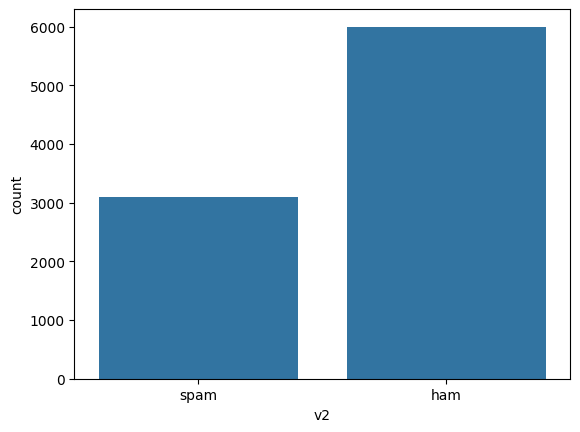

In [5]:
sns.countplot(x='v2', data=df)
plt.show()


In [ ]:
# 1. Data cleaning
df.drop( columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace = True)


In [6]:
df

,v1,v2
0,"Congratulations! You have received a $1,000,00...",spam
1,"Congratulations! You have received a $1,000,00...",spam
2,"Congratulations! You have received a $1,000,00...",spam
3,"Great news! You have received a $1,000,000 dep...",spam
4,"Congratulations! A transfer of $1,000,000 has ...",spam
...,...,...
9093,Weekly Newsletter: You are invited to a birthd...,ham
9094,Medical Appointment Reminder: We have received...,ham
9095,Event Registration Confirmation: Thank you for...,ham
9096,Project Update: Your order has been confirmed ...,ham


In [7]:
df.sample(3)

,v1,v2
4159,Your Order Confirmation: You are invited to a ...,ham
2219,Weekly Newsletter: Here is the monthly report ...,ham
766,Congratulations! You are the recipient of a $1...,spam


In [8]:
df.rename(columns = {'v1' :'text','v2':'target'}, inplace = True)

In [9]:
df

,text,target
0,"Congratulations! You have received a $1,000,00...",spam
1,"Congratulations! You have received a $1,000,00...",spam
2,"Congratulations! You have received a $1,000,00...",spam
3,"Great news! You have received a $1,000,000 dep...",spam
4,"Congratulations! A transfer of $1,000,000 has ...",spam
...,...,...
9093,Weekly Newsletter: You are invited to a birthd...,ham
9094,Medical Appointment Reminder: We have received...,ham
9095,Event Registration Confirmation: Thank you for...,ham
9096,Project Update: Your order has been confirmed ...,ham


In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [11]:
df['target']=encoder.fit_transform(df['target'])

In [12]:
df

,text,target
0,"Congratulations! You have received a $1,000,00...",1
1,"Congratulations! You have received a $1,000,00...",1
2,"Congratulations! You have received a $1,000,00...",1
3,"Great news! You have received a $1,000,000 dep...",1
4,"Congratulations! A transfer of $1,000,000 has ...",1
...,...,...
9093,Weekly Newsletter: You are invited to a birthd...,0
9094,Medical Appointment Reminder: We have received...,0
9095,Event Registration Confirmation: Thank you for...,0
9096,Project Update: Your order has been confirmed ...,0


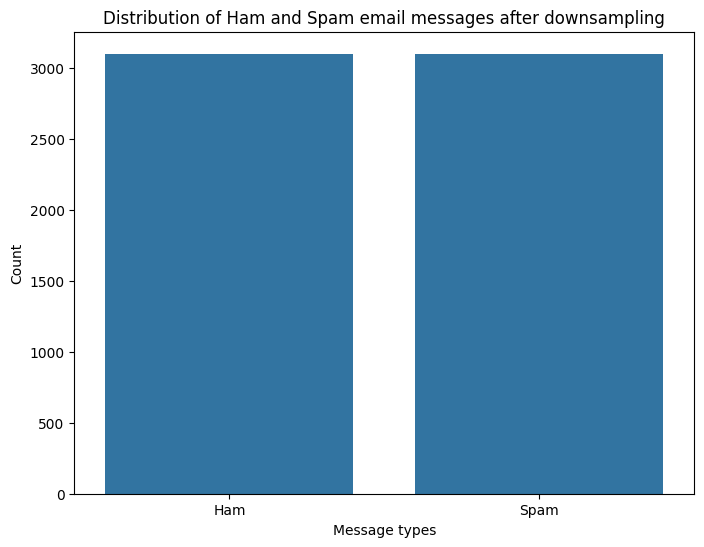

In [13]:
ham_msg = df[df.target == 0]
spam_msg = df[df.target == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Concatenate the downsampled DataFrames
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)

# Plot the counts of the balanced dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='target')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

In [14]:
df

,text,target
0,"Congratulations! You have received a $1,000,00...",1
1,"Congratulations! You have received a $1,000,00...",1
2,"Congratulations! You have received a $1,000,00...",1
3,"Great news! You have received a $1,000,000 dep...",1
4,"Congratulations! A transfer of $1,000,000 has ...",1
...,...,...
9093,Weekly Newsletter: You are invited to a birthd...,0
9094,Medical Appointment Reminder: We have received...,0
9095,Event Registration Confirmation: Thank you for...,0
9096,Project Update: Your order has been confirmed ...,0


In [15]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,text,target
0,Family Reunion Plans: Here is the latest updat...,0
1,Weekly Newsletter: Just a reminder about our m...,0
2,Flight Itinerary: We have received your job ap...,0
3,Important Notice: We have received your job ap...,0
4,Reminder: Submission Deadline: Details for the...,0


In [16]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	# Convert the text to a string if it's not already a string
	text = str(text)
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,target
0,Family Reunion Plans Here is the latest update...,0
1,Weekly Newsletter Just a reminder about our me...,0
2,Flight Itinerary We have received your job app...,0
3,Important Notice We have received your job app...,0
4,Reminder Submission Deadline Details for the u...,0


In [17]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,target
0,family reunion plans latest update project com...,0
1,weekly newsletter reminder meeting scheduled t...,0
2,flight itinerary received job application revi...,0
3,important notice received job application revi...,0
4,reminder submission deadline details upcoming ...,0


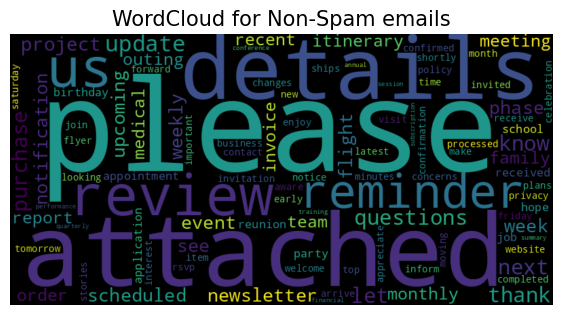

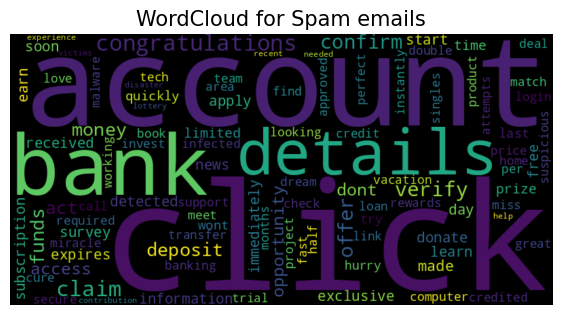

In [18]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['target'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['target'] == 1], typ='Spam')


In [19]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['target'],
													test_size = 0.2,
													random_state = 42)


In [20]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


In [21]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=128,  # dimension barano hoieche
                                    input_length=max_len))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.5))  # 50% dropout added
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          34688     
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [22]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [23]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [24]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
155/155 [==============================] - 20s 67ms/step - loss: 0.6201 - accuracy: 0.9603 - val_loss: 0.1629 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - 5s 29ms/step - loss: 0.0806 - accuracy: 1.0000 - val_loss: 0.0370 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/20
155/155 [==============================] - 5s 31ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/20
155/155 [==============================] - 3s 21ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 1.0000 - lr: 0.0010


In [25]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


39/39 [==============================] - 0s 10ms/step - loss: 0.1629 - accuracy: 1.0000
Test Loss : 0.16288909316062927
Test Accuracy : 1.0


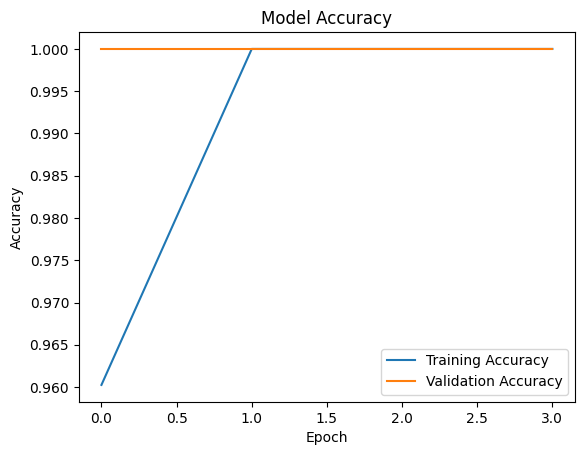

In [26]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [28]:
from tensorflow.keras.models import load_model
import pickle


model = load_model('model.h5')


model_json = model.to_json()
with open('spam_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)


weights = model.get_weights()
with open('model.pkl', 'wb') as file:
    pickle.dump(weights, file)


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer


texts = df['text'].astype(str).tolist()

#  TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(texts)

print("TF-IDF vectorizer has been fitted successfully.")


TF-IDF vectorizer has been fitted successfully.


In [30]:
import pickle

# Save
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

print("TF-IDF vectorizer has been saved successfully.")


TF-IDF vectorizer has been saved successfully.


In [31]:
import pickle

# Save
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

print("TF-IDF vectorizer has been saved successfully.")


TF-IDF vectorizer has been saved successfully.


In [ ]:
#..................main part done above .........abyss

In [33]:
from google.colab import files

# Download the vectorizer file
files.download('vectorizer.pkl')

# Download the model file
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:

model.save('model.h5')  #  H5 file


In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs

# Convertion of model from h5 to tfjs
tfjs.converters.save_keras_model(model, 'tfjs_model')


failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
import shutil

shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')


'/content/tfjs_model.zip'

In [ ]:
from google.colab import files

files.download('tfjs_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>